# Visualizer of all .mat files
va a escampar - la vela puerca

### obsolete

In [ ]:
#version 1
import os
import h5py
import numpy as np
import pandas as pd
from scipy.io import loadmat

folder_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/"

# Lista para almacenar los resultados temporalmente
resultados = []
count = 0 #183 mat in XB47Y

for filename in os.listdir(folder_path):
    if not filename.lower().endswith(".mat") or filename.startswith('.'):
        continue
    file_path = os.path.join(folder_path, filename)
    T0 = None  
    
    # --- PASO 1: CARGAR EL ARCHIVO Y EXTRAER T0 ---
    try:
        data_mat = loadmat(file_path)
        hdr = data_mat["hdr"]
        # Extraer T0 para Scipy (acceso a struct anidado)
        T0 = hdr["orig"][0, 0]["T0"][0, 0]
        
    except (ValueError, NotImplementedError, KeyError):
        try:
            # Intento con HDF5 (v7.3)
            with h5py.File(file_path, 'r') as f:
                # La estructura en HDF5 puede variar según cómo se guardó
                # Si es una referencia, usamos f[ref], si es valor directo f['path']
                T0_data = f['hdr']['orig']['T0']
                if isinstance(T0_data, h5py.Dataset):
                    T0 = T0_data[()].item()
                else: # Si es una referencia
                    T0 = f[T0_data[0, 0]][()].item()
        except Exception as e:
            print(f"No se pudo extraer T0 de {filename}: {e}")
            continue

    # Si logramos obtener el T0, lo guardamos junto al nombre del archivo
    if T0 is not None:
        resultados.append({
            "Archivo": filename,
            "T0": T0
        })
        count += 1

# --- PASO 2: CREAR EL DATAFRAME ---
df_resultados = pd.DataFrame(resultados)

# Mostrar los primeros resultados y el total
print(df_resultados.head())
print(f"\nTotal number of files: {count}")
print(count)
# Opcional: Guardar a CSV
# df_resultados.to_csv("lista_t0.csv", index=False)

In [ ]:
#version 2
import os
import h5py
import numpy as np
import pandas as pd
from scipy.io import loadmat

folder_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/"

resultados = []

for filename in os.listdir(folder_path):
    if not filename.lower().endswith(".mat") or filename.startswith('.'):
        continue
    
    file_path = os.path.join(folder_path, filename)
    
    try:
        # --- CARGA CON SCIPY ---
        data_mat = loadmat(file_path)
        hdr = data_mat["hdr"]
        
        # 1. Extraer T0
        T0 = hdr["orig"][0, 0]["T0"][0, 0]
        
        # 2. Extraer Frecuencia de Muestreo (fs)
        fs = float(hdr['Fs'][0,0].item())
        
        # 3. Extraer Señal y calcular Duración
        signal = np.asarray(data_mat['data'])
        
        # Verificación de transposición (tu lógica)
        # Necesitamos saber cuántos canales hay para validar la forma
        channels_raw = hdr['label'][0,0]
        n_channels = channels_raw.shape[0]
        
        if signal.shape[1] != n_channels and signal.shape[0] == n_channels:
            signal = signal.T
            
        n_samples = signal.shape[0]
        total_time = n_samples / fs  # Tiempo total en segundos
        
        # Guardar en la lista
        resultados.append({
            ".mat file": filename,
            "T0": T0,
            "time (s)": total_time,
            "samples": n_samples
        })

    except Exception as e:
        print(f"Error procesando {filename}: {e}")
        continue

# --- CREAR EL DATAFRAME FINAL ---
df_final = pd.DataFrame(resultados)

# Mostrar tabla resultante
print(df_final.head())

# Si quieres ver el tiempo total acumulado de todos los archivos:
print(f"\nTotal time in hours: {df_final['time (s)'].sum() / 3600:.2f} hours")


In [ ]:
#version 3
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from datetime import datetime, timedelta

folder_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/"
resultados = []

for filename in os.listdir(folder_path):
    if not filename.lower().endswith(".mat") or filename.startswith('.'):
        continue
    
    file_path = os.path.join(folder_path, filename)
    
    try:
        data_mat = loadmat(file_path)
        hdr = data_mat["hdr"]
        
        # --- 1. EXTRAER Y FORMATEAR T0 ---
        # T0 is like[[2019, 10, 30, 1, 54, 13]]
        t0_raw = hdr["orig"][0, 0]["T0"][0, 0][0] 
        
        # Convert into object datetime
        # datetime(year, month, day, hour, minute, second)
        t0_dt = datetime(int(t0_raw[0]), int(t0_raw[1]), int(t0_raw[2]), 
                         int(t0_raw[3]), int(t0_raw[4]), int(t0_raw[5]))
        
        # --- 2. CALCULAR DURACIÓN Y TF ---
        fs = float(hdr['Fs'][0,0].item())
        signal = np.asarray(data_mat['data'])
        
        # Lógica de transposición para obtener n_samples
        channels_raw = hdr['label'][0,0]
        n_channels = channels_raw.shape[0]
        if signal.shape[1] != n_channels and signal.shape[0] == n_channels:
            signal = signal.T
            
        n_samples = signal.shape[0]
        duracion_segundos = n_samples / fs
        
        # TF = T0 + Duración
        tf_dt = t0_dt + timedelta(seconds=duracion_segundos)
        
        # Guardar en la lista
        resultados.append({
            "Archivo": filename,
            "T0": t0_dt,
            "Duración (s)": round(duracion_segundos, 2),
            "TF": tf_dt
        })

    except Exception as e:
        print(f"Error en {filename}: {e}")
        continue

# --- 3. CREAR DATAFRAME ---
df_final = pd.DataFrame(resultados)

# Ordenar por T0 para que la cronología tenga sentido
df_final = df_final.sort_values(by="T0").reset_index(drop=True)

print(df_final.head())

### Version final

In [3]:
#version final
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from datetime import datetime, timedelta

folder_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/"
resultados = []

for filename in os.listdir(folder_path):
    if not filename.lower().endswith(".mat") or filename.startswith('.'):
        continue
    
    file_path = os.path.join(folder_path, filename)
    
    try:
        data_mat = loadmat(file_path)
        hdr = data_mat["hdr"]
        
        # Format T0: [[2019, 10, 30, 1, 54, 13]]
        t0_raw = hdr["orig"][0, 0]["T0"][0, 0][0]
        t0_dt = datetime(int(t0_raw[0]), int(t0_raw[1]), int(t0_raw[2]), 
                         int(t0_raw[3]), int(t0_raw[4]), int(t0_raw[5]))
        
        # calculate duration and Fs
        fs = float(hdr['Fs'][0,0].item())
        signal = np.asarray(data_mat['data'])
        

        channels_raw = hdr['label'][0,0]
        n_channels = channels_raw.shape[0]
        if signal.shape[1] != n_channels and signal.shape[0] == n_channels:
            signal = signal.T
            
        n_samples = signal.shape[0]
        duracion_segundos = n_samples / fs
        tf_dt = t0_dt + timedelta(seconds=duracion_segundos)
        
        resultados.append({
            "file": filename,
            "T0": t0_dt,
            "TF": tf_dt,
            "time (s)": round(duracion_segundos, 2)
        })

    except Exception as e:
        print(f"Error in {filename}: {e}")

# 2. Calculate GAP
df = pd.DataFrame(resultados)
# sort values by T0, to assure a proper gap calculation
df = df.sort_values(by="T0").reset_index(drop=True)

# calculate gap from previous file
# .diff() calcula la diferencia con la fila anterior
df['Gap (s)'] = (df['T0'] - df['TF'].shift(1)).dt.total_seconds()

# Opcional: Para el primer archivo el Gap será NaN, podemos ponerlo en 0
df['Gap (s)'] = df['Gap (s)'].fillna(0)

# 3. visualize table
print(df[['file', 'T0', 'TF', 'time (s)', 'Gap (s)']].head(10))

# summary
gaps_significativos = df[df['Gap (s)'] > 1] # Gaps mayores a 1 segundo
print(f"\n there was found {len(gaps_significativos)} gaps between records")

            file                  T0                         TF  time (s)  \
0   XB47Y_35.mat 2019-10-29 09:31:04 2019-10-29 10:01:00.730450   1796.73   
1   XB47Y_37.mat 2019-10-29 19:54:13 2019-10-30 01:54:12.759550  21599.76   
2   XB47Y_38.mat 2019-10-30 01:54:13 2019-10-30 04:58:50.338150  11077.34   
3   XB47Y_98.mat 2019-10-30 07:47:44 2019-10-30 13:47:44.759400  21600.76   
4   XB47Y_99.mat 2019-10-30 13:47:44 2019-10-30 19:47:44.759400  21600.76   
5  XB47Y_100.mat 2019-10-30 19:47:44 2019-10-31 01:47:44.759400  21600.76   
6  XB47Y_101.mat 2019-10-31 01:47:44 2019-10-31 05:01:37.254750  11633.25   
7   XB47Y_39.mat 2019-10-31 07:46:05 2019-10-31 13:46:04.759550  21599.76   
8   XB47Y_40.mat 2019-10-31 13:46:05 2019-10-31 19:46:05.759400  21600.76   
9   XB47Y_41.mat 2019-10-31 19:46:05 2019-11-01 01:46:05.759400  21600.76   

       Gap (s)  
0      0.00000  
1  35592.26955  
2      0.24045  
3  10133.66185  
4     -0.75940  
5     -0.75940  
6     -0.75940  
7   9867.74525  

## Plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
events = []

for _, row in df.iterrows():
    events.append((row["T0"], 1))
    events.append((row["TF"], 0))

events_df = pd.DataFrame(events, columns=["Time", "Presence"])
events_df = events_df.sort_values("Time")
plt.figure(figsize=(14,4))
plt.step(events_df["Time"], events_df["Presence"], where="post")
plt.ylim(-0.1, 1.1)
plt.xlabel("Time")
plt.ylabel("Signal Presence")
plt.title("EEG Recording Availability Over Time")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create start/end events (1 = presence, 0 = absence)
events = []

for _, row in df.iterrows():
    events.append((row["T0"], 1))  # signal starts
    events.append((row["TF"], 0))  # signal ends

# Convert to DataFrame and sort chronologically
events_df = pd.DataFrame(events, columns=["Time", "Presence"])
events_df = events_df.sort_values("Time")
n_presences = (events_df["Presence"] == 1).sum()
print("Number of recording intervals:", n_presences)
# Get total time range
t_min = events_df["Time"].min()
t_max = events_df["Time"].max()

# Divide total time span into 4 equal segments
time_splits = pd.date_range(start=t_min, end=t_max, periods=5)

# Create 4 vertical subplots (shared Y-axis)
fig, axes = plt.subplots(4, 1, figsize=(14,10), sharey=True)

for i in range(4):
    ax = axes[i]
    
    # Define time window for this subplot
    start = time_splits[i]
    end = time_splits[i+1]
    
    # Select only data within this time window
    mask = (events_df["Time"] >= start) & (events_df["Time"] <= end)
    subset = events_df[mask]
    
    # Plot step function (binary presence signal)
    ax.step(subset["Time"], subset["Presence"], where="post")
    
    # Adjust axis limits
    ax.set_xlim(start, end)
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("Presence")

# Label only the bottom subplot with X-axis
axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Over Time (Split into 4 Panels)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])

# Create start/end events (1 = presence, 0 = absence)
events = []

for _, row in df.iterrows():
    events.append((row["T0"], 1))  # recording starts
    events.append((row["TF"], 0))  # recording ends

events_df = pd.DataFrame(events, columns=["Time", "Presence"])
events_df = events_df.sort_values("Time")

# Extract unique days
events_df["Date"] = events_df["Time"].dt.date
unique_days = events_df["Date"].unique()

# Create one subplot per day
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)

# If there is only one day, make axes iterable
if len(unique_days) == 1:
    axes = [axes]

for ax, day in zip(axes, unique_days):
    
    # Filter events for this day
    day_data = events_df[events_df["Date"] == day]
    
    ax.step(day_data["Time"], day_data["Presence"], where="post")
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("Presence")
    ax.set_title(f"Date: {day}")
    
    # Limit x-axis to that full day
    start_day = pd.Timestamp(day)
    end_day = start_day + pd.Timedelta(days=1)
    ax.set_xlim(start_day, end_day)

axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Per Day")
plt.tight_layout()
plt.show()


## Plot with seizures

In [5]:
# RED sqEEG
# green diary
import pandas as pd
p_folder_path = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y"
seizure_file = "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/XB47Y_seizures.xlsx"

# Ver nombres de sheets
xls = pd.ExcelFile(seizure_file)
print(xls.sheet_names)

# expected sheets: ['sqEEG', 'diary']
from pathlib import Path
# Creating the folder where the csv are gonna be. each of the resulting sheets


base_dir = Path("/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y")
#patient anon name: eg: xb47y
anon_name = base_dir.name.upper()

folder_name = f"preprocessCSV_{anon_name}"
folder_path = base_dir / folder_name


folder_path.mkdir(parents=True, exist_ok=True)

print(folder_path)
# first data frame for each sheet then I save it as individual csv
# then I can map them separetey to finde the seizures times
df_sqEEG = pd.read_excel(seizure_file, sheet_name="sqEEG")
df_diary = pd.read_excel(seizure_file, sheet_name="diary")

# saved into the folder I created in the prev cell
df_sqEEG.to_csv(folder_path / "sqEEG.csv", index=False)
df_diary.to_csv(folder_path / "diary.csv", index=False)

#df3 = pd.concat([df_diary, df_sqEEG], axis=1)
# no es buena idea concatenarlo porque tienen distinto numero de cosas
#convert each df into a datetime format
df_diary["Timestamp"] = pd.to_datetime(df_diary["Timestamp"])
#df_diary["T"] = pd.to_datetime(df_diary["Timestamp"])
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])


['sqEEG', 'diary']
/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/data/Working/XB47Y/preprocessCSV_XB47Y


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])

# Create start/end events (1 = presence, 0 = absence)
events = []

for _, row in df.iterrows():
    events.append((row["T0"], 1))  # recording starts
    events.append((row["TF"], 0))  # recording ends

events_df = pd.DataFrame(events, columns=["Time", "Presence"])
events_df = events_df.sort_values("Time")

# Extract unique days
events_df["Date"] = events_df["Time"].dt.date
unique_days = events_df["Date"].unique()

# Create one subplot per day
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)

# If there is only one day, make axes iterable
if len(unique_days) == 1:
    axes = [axes]
for ax, day in zip(axes, unique_days):
    
    day_data = events_df[events_df["Date"] == day]
    ax.step(day_data["Time"], day_data["Presence"], where="post")
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("Presence")
    ax.set_title(f"Date: {day}")
    
    start_day = pd.Timestamp(day)
    end_day = start_day + pd.Timedelta(days=1)
    ax.set_xlim(start_day, end_day)

    # 🔴 FILTRAR eventos que caen en ese día
    day_marks_seizure = df_sqEEG[
        (df_sqEEG["onset"] >= start_day) &
        (df_sqEEG["onset"] < end_day)
    ]

    # 🔴 DIBUJAR LINEAS VERTICALES
    for event_time in day_marks_seizure["onset"]:
        ax.axvline(event_time, color="red", linestyle="--", linewidth=1.5)

axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Per Day")
plt.tight_layout()
plt.savefig("/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/results/XB47Y_EEG_recording_availability_per_dayONSET.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])

# Create start/end events (1 = presence, 0 = absence)
events = []

for _, row in df.iterrows():
    events.append((row["T0"], 1))  # recording starts
    events.append((row["TF"], 0))  # recording ends
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])

print("\nMatching onsets inside recording intervals:\n")

for _, seizure_row in df_sqEEG.iterrows():
    onset_time = seizure_row["onset"]
    
    matching_intervals = df[
        (df["T0"] <= onset_time) &
        (df["TF"] >= onset_time)
    ]
    
    for _, match in matching_intervals.iterrows():
        print(f"File: {match['file']} | Onset: {onset_time} | Interval: {match['T0']} -> {match['TF']}")

events_df = pd.DataFrame(events, columns=["Time", "Presence"])
events_df = events_df.sort_values("Time")

# Extract unique days
events_df["Date"] = events_df["Time"].dt.date
unique_days = events_df["Date"].unique()

# Create one subplot per day
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)

# If there is only one day, make axes iterable
if len(unique_days) == 1:
    axes = [axes]
for ax, day in zip(axes, unique_days):
    
    day_data = events_df[events_df["Date"] == day]
    ax.step(day_data["Time"], day_data["Presence"], where="post")
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("Presence")
    ax.set_title(f"Date: {day}")
    
    start_day = pd.Timestamp(day)
    end_day = start_day + pd.Timedelta(days=1)
    ax.set_xlim(start_day, end_day)

    # 🔴 FILTRAR eventos que caen en ese día
    day_marks_seizure = df_sqEEG[
        (df_sqEEG["onset"] >= start_day) &
        (df_sqEEG["onset"] < end_day)
    ]

    # 🔴 DIBUJAR LINEAS VERTICALES
    for event_time in day_marks_seizure["onset"]:
        ax.axvline(event_time, color="red", linestyle="--", linewidth=1.5)

axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Per Day")
plt.tight_layout()
plt.savefig("/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/results/XB47Y_EEG_recording_availability_per_dayONSET.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])

# Create start/end events (1 = presence, 0 = absence)
events = []

for _, row in df.iterrows():
    events.append((row["T0"], 1))  # recording starts
    events.append((row["TF"], 0))  # recording ends

events_df = pd.DataFrame(events, columns=["Time", "Presence"])
events_df = events_df.sort_values("Time")

# Extract unique days
events_df["Date"] = events_df["Time"].dt.date
unique_days = events_df["Date"].unique()

# Create one subplot per day
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)

# If there is only one day, make axes iterable
if len(unique_days) == 1:
    axes = [axes]
for ax, day in zip(axes, unique_days):
    
    day_data = events_df[events_df["Date"] == day]
    ax.step(day_data["Time"], day_data["Presence"], where="post")
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("Presence")
    ax.set_title(f"Date: {day}")
    
    start_day = pd.Timestamp(day)
    end_day = start_day + pd.Timedelta(days=1)
    ax.set_xlim(start_day, end_day)

    #GREEN FILTRAR eventos que caen en ese día
    day_marks_diary = df_diary[
        (df_diary["Timestamp"] >= start_day) &
        (df_diary["Timestamp"] < end_day)
    ]

    # Green: DIBUJAR LINEAS VERTICALES
    for event_time in day_marks_diary["Timestamp"]:
        ax.axvline(event_time, color="green", linestyle="--", linewidth=1.5)

axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Per Day")
plt.tight_layout()
plt.savefig("/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/results/XB47Y_EEG_recording_availability_per_dayDIARY.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configuración del gráfico
plt.figure(figsize=(15, 4))

# Iteramos sobre cada fila de tu DataFrame ya procesado
for i, row in df.iterrows():
    # Dibujamos una línea horizontal para cada archivo
    # El eje Y es 1 (Presencia de señal)
    # El color 'tab:blue' es para los bloques de datos
    plt.hlines(y=1, xmin=row['T0'], xmax=row['TF'], 
               linewidth=10, color='royalblue', label='Señal' if i == 0 else "")

# Si quieres representar los Gaps explícitamente a Y=0
# Buscamos donde el Gap sea mayor a 0
for i in range(1, len(df)):
    gap_inicio = df.iloc[i-1]['TF']
    gap_fin = df.iloc[i]['T0']
    
    if gap_fin > gap_inicio:
        plt.hlines(y=0, xmin=gap_inicio, xmax=gap_fin, 
                   linewidth=2, color='red', linestyle='--', label='Gap' if i == 1 else "")

# Configuración de los ejes
plt.ylim(-0.5, 1.5)
plt.yticks([0, 1], ['Ausencia (Gap)', 'Presencia (Dato)'])
plt.title(f"Cronología de Grabaciones EEG - Carpeta: {folder_path.split('/')[-2]}", fontsize=14)
plt.xlabel("Tiempo (HH:MM)")

# Formatear el eje X para mostrar fechas/horas legibles
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

## Debugging the code:


Matching onsets inside recording intervals:

File: XB47Y_41.mat | Onset: 2019-10-31 23:25:08.153000 | Interval: 2019-10-31 19:46:05 -> 2019-11-01 01:46:05.759400
File: XB47Y_102.mat | Onset: 2019-11-01 09:51:15.667000 | Interval: 2019-11-01 07:43:13 -> 2019-11-01 13:43:13.759400
File: XB47Y_103.mat | Onset: 2019-11-01 14:50:01.176000 | Interval: 2019-11-01 13:43:13 -> 2019-11-01 19:43:13.759400
File: XB47Y_44.mat | Onset: 2019-11-03 01:15:24.492000 | Interval: 2019-11-02 23:04:32 -> 2019-11-03 01:52:11.490850
File: XB47Y_44.mat | Onset: 2019-11-03 01:49:23.993000 | Interval: 2019-11-02 23:04:32 -> 2019-11-03 01:52:11.490850
File: XB47Y_51.mat | Onset: 2019-11-05 23:44:28.598000 | Interval: 2019-11-05 19:39:22 -> 2019-11-06 01:39:22.759400
File: XB47Y_110.mat | Onset: 2019-11-06 11:13:20.650000 | Interval: 2019-11-06 07:42:43 -> 2019-11-06 13:42:42.759550
File: XB47Y_54.mat | Onset: 2019-11-08 14:45:24.441000 | Interval: 2019-11-08 13:40:20 -> 2019-11-08 14:56:31.314200
File: XB47Y_56.

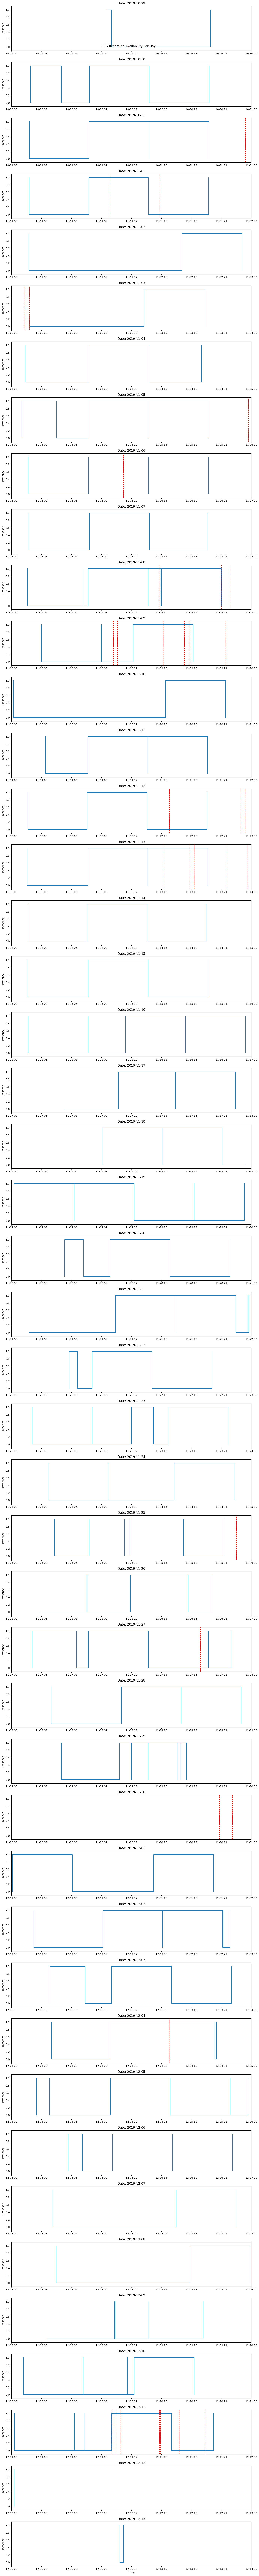

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])

# Create start/end events (1 = presence, 0 = absence)
events = []

for _, row in df.iterrows():
    events.append((row["T0"], 1))  # recording starts
    events.append((row["TF"], 0))  # recording ends
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])

print("\nMatching onsets inside recording intervals:\n")

for _, seizure_row in df_sqEEG.iterrows():
    onset_time = seizure_row["onset"]
    
    matching_intervals = df[
        (df["T0"] <= onset_time) &
        (df["TF"] >= onset_time)
    ]
    
    for _, match in matching_intervals.iterrows():
        print(f"File: {match['file']} | Onset: {onset_time} | Interval: {match['T0']} -> {match['TF']}")

events_df = pd.DataFrame(events, columns=["Time", "Presence"])
events_df = events_df.sort_values("Time")

# Extract unique days
events_df["Date"] = events_df["Time"].dt.date
unique_days = events_df["Date"].unique()

# Create one subplot per day
fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)

# If there is only one day, make axes iterable
if len(unique_days) == 1:
    axes = [axes]
for ax, day in zip(axes, unique_days):
    
    day_data = events_df[events_df["Date"] == day]
    ax.step(day_data["Time"], day_data["Presence"], where="post")
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("Presence")
    ax.set_title(f"Date: {day}")
    
    start_day = pd.Timestamp(day)
    end_day = start_day + pd.Timedelta(days=1)
    ax.set_xlim(start_day, end_day)

    # 🔴 FILTRAR eventos que caen en ese día
    day_marks_seizure = df_sqEEG[
        (df_sqEEG["onset"] >= start_day) &
        (df_sqEEG["onset"] < end_day)
    ]

    # 🔴 DIBUJAR LINEAS VERTICALES
    for event_time in day_marks_seizure["onset"]:
        ax.axvline(event_time, color="red", linestyle="--", linewidth=1.5)

axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Per Day")
plt.tight_layout()
plt.savefig("/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/results/XB47Y_EEG_recording_availability_per_dayONSET.png", dpi=300, bbox_inches="tight")
plt.show()


In [7]:
print("df T0 dtype:", df["T0"].dtype, " | TF dtype:", df["TF"].dtype)
print("sqEEG onset dtype:", df_sqEEG["onset"].dtype)

print("\nNaT counts:")
print("T0 NaT:", df["T0"].isna().sum(), "TF NaT:", df["TF"].isna().sum())
print("onset NaT:", df_sqEEG["onset"].isna().sum())

print("\nMin/Max:")
print("T0:", df["T0"].min(), "->", df["T0"].max())
print("TF:", df["TF"].min(), "->", df["TF"].max())
print("onset:", df_sqEEG["onset"].min(), "->", df_sqEEG["onset"].max())

# Si esto da error o cosas raras, casi seguro es timezone mix o parsing malo
try:
    print("\nTimezone info:")
    print("T0 tz:", getattr(df["T0"].dt, "tz", None))
    print("onset tz:", getattr(df_sqEEG["onset"].dt, "tz", None))
except Exception as e:
    print("TZ check error:", e)

# intervalos inválidos
bad = (df["TF"] < df["T0"]).sum()
print("\nIntervals where TF < T0:", bad)


df T0 dtype: datetime64[ns]  | TF dtype: datetime64[ns]
sqEEG onset dtype: datetime64[ns]

NaT counts:
T0 NaT: 0 TF NaT: 0
onset NaT: 0

Min/Max:
T0: 2019-10-29 09:31:04 -> 2019-12-13 11:13:30
TF: 2019-10-29 10:01:00.730450 -> 2019-12-13 11:14:08.994150
onset: 2019-10-31 23:25:08.153000 -> 2019-12-11 19:22:08.918000

Timezone info:
T0 tz: None
onset tz: None

Intervals where TF < T0: 0


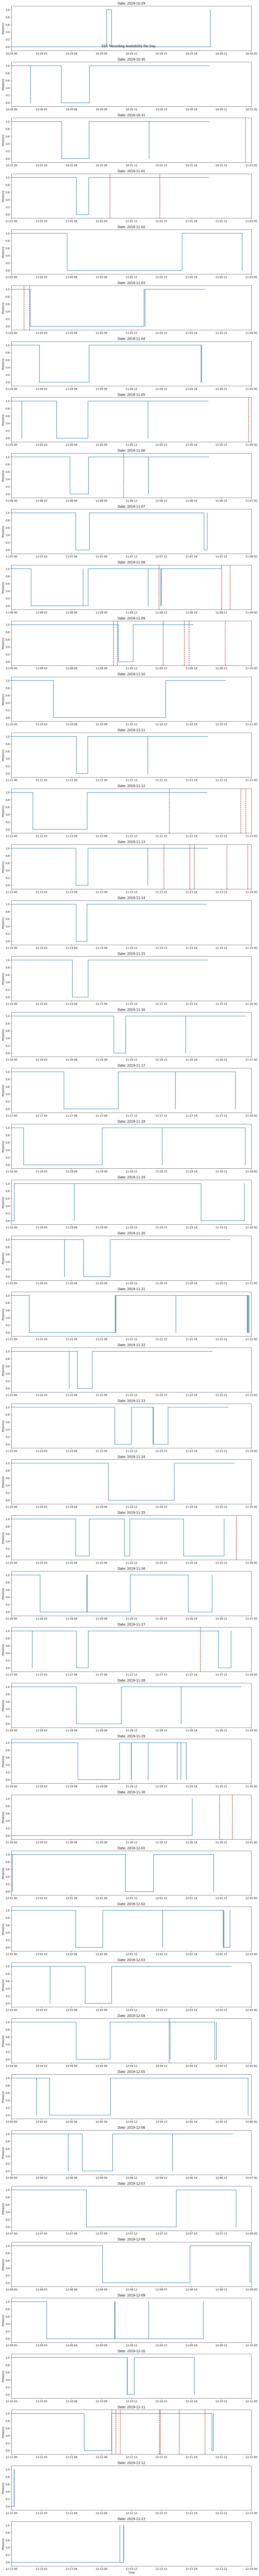

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime format (ya lo tenés)
df["T0"] = pd.to_datetime(df["T0"])
df["TF"] = pd.to_datetime(df["TF"])
df_sqEEG["onset"] = pd.to_datetime(df_sqEEG["onset"])

# --- 1) Eventos como deltas (+1 start, -1 end) ---
events = []
for _, row in df.iterrows():
    events.append((row["T0"], +1))
    events.append((row["TF"], -1))

events_df = pd.DataFrame(events, columns=["Time", "Delta"]).sort_values("Time")

# Si hay eventos con el mismo timestamp, los sumamos
events_df = events_df.groupby("Time", as_index=False)["Delta"].sum().sort_values("Time")

# --- 2) Estado acumulado -> presencia binaria ---
events_df["State"] = events_df["Delta"].cumsum()
events_df["Presence"] = (events_df["State"] > 0).astype(int)

# Días (mejor floor que .dt.date)
events_df["DayStart"] = events_df["Time"].dt.floor("D")
unique_days = events_df["DayStart"].unique()

fig, axes = plt.subplots(len(unique_days), 1, figsize=(14, 3*len(unique_days)), sharey=True)
if len(unique_days) == 1:
    axes = [axes]

for ax, start_day in zip(axes, unique_days):
    start_day = pd.Timestamp(start_day)
    end_day = start_day + pd.Timedelta(days=1)

    day_data = events_df[(events_df["Time"] >= start_day) & (events_df["Time"] < end_day)].copy()

    # --- 3) Baseline: estado al inicio del día ---
    # (para que el plot arranque correcto aunque el primer evento sea más tarde)
    prev_state = events_df.loc[events_df["Time"] < start_day, "State"]
    presence_at_start = int(prev_state.iloc[-1] > 0) if len(prev_state) else 0

    # Insertar punto inicial del día
    day_data = pd.concat(
        [pd.DataFrame({"Time": [start_day], "Presence": [presence_at_start]}),
         day_data[["Time", "Presence"]]],
        ignore_index=True
    ).sort_values("Time")

    ax.step(day_data["Time"], day_data["Presence"], where="post")
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("Presence")
    ax.set_title(f"Date: {start_day.date()}")
    ax.set_xlim(start_day, end_day)

    # Onsets del día
    day_marks_seizure = df_sqEEG[(df_sqEEG["onset"] >= start_day) & (df_sqEEG["onset"] < end_day)]
    for event_time in day_marks_seizure["onset"]:
        ax.axvline(event_time, color="red", linestyle="--", linewidth=1.5)

axes[-1].set_xlabel("Time")

plt.suptitle("EEG Recording Availability Per Day")
plt.tight_layout()
plt.savefig(
    "/home/tperezsanchez/FoundationModel_EEG_Dissertation/EEG_data_vis/results/XB47Y_EEG_recording_availability_per_dayONSET.png",
    dpi=300, bbox_inches="tight"
)
plt.show()


In [9]:
print(events_df[["Time","Delta","State","Presence"]].head(10))
print("State min/max:", events_df["State"].min(), events_df["State"].max())


                        Time  Delta  State  Presence
0 2019-10-29 09:31:04.000000      1      1         1
1 2019-10-29 10:01:00.730450     -1      0         0
2 2019-10-29 19:54:13.000000      1      1         1
3 2019-10-30 01:54:12.759550     -1      0         0
4 2019-10-30 01:54:13.000000      1      1         1
5 2019-10-30 04:58:50.338150     -1      0         0
6 2019-10-30 07:47:44.000000      1      1         1
7 2019-10-30 13:47:44.000000      1      2         1
8 2019-10-30 13:47:44.759400     -1      1         1
9 2019-10-30 19:47:44.000000      1      2         1
State min/max: 0 2


In [10]:
df_sorted = df.sort_values("T0").reset_index(drop=True)
df_sorted["prev_TF"] = df_sorted["TF"].shift(1)
df_sorted["overlap_s"] = (df_sorted["prev_TF"] - df_sorted["T0"]).dt.total_seconds()

print("Overlaps (prev_TF > T0):")
print(df_sorted[df_sorted["overlap_s"] > 0][["file","T0","TF","prev_TF","overlap_s"]].head(20))



Overlaps (prev_TF > T0):
             file                  T0                         TF  \
4    XB47Y_99.mat 2019-10-30 13:47:44 2019-10-30 19:47:44.759400   
5   XB47Y_100.mat 2019-10-30 19:47:44 2019-10-31 01:47:44.759400   
6   XB47Y_101.mat 2019-10-31 01:47:44 2019-10-31 05:01:37.254750   
9    XB47Y_41.mat 2019-10-31 19:46:05 2019-11-01 01:46:05.759400   
10   XB47Y_42.mat 2019-11-01 01:46:05 2019-11-01 06:30:16.441900   
12  XB47Y_103.mat 2019-11-01 13:43:13 2019-11-01 19:43:13.759400   
13  XB47Y_104.mat 2019-11-01 19:43:13 2019-11-02 01:43:13.759400   
14  XB47Y_105.mat 2019-11-02 01:43:13 2019-11-02 05:34:26.918600   
19   XB47Y_47.mat 2019-11-03 19:21:22 2019-11-04 01:21:22.759400   
20   XB47Y_48.mat 2019-11-04 01:21:22 2019-11-04 02:47:33.224200   
22  XB47Y_107.mat 2019-11-04 13:46:20 2019-11-04 18:57:41.197400   
27   XB47Y_51.mat 2019-11-05 19:39:22 2019-11-06 01:39:22.759400   
28   XB47Y_52.mat 2019-11-06 01:39:22 2019-11-06 05:51:05.734100   
31  XB47Y_112.mat 2019-